In [0]:
! pip install cdindex

Collecting cdindex
 Downloading cdindex-1.0.19.tar.gz (9.6 kB)
Requirement already satisfied: future in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from cdindex) (0.18.2)
Building wheels for collected packages: cdindex
 Building wheel for cdindex (setup.py) ... - \ | done
 Created wheel for cdindex: filename=cdindex-1.0.19-cp38-cp38-linux_x86_64.whl size=29601 sha256=0a693d38e56cb85a3aeaabfe46279a051b2a0a3951ba5d3004196c30d2347cb7
 Stored in directory: /root/.cache/pip/wheels/71/13/93/041928bfeac45447f347a7e06bff652b290da049acf7761f5c
Successfully built cdindex
Installing collected packages: cdindex
Successfully installed cdindex-1.0.19

In [0]:
import urllib.request
import cdindex
import datetime
import zipfile
import requests, zipfile, io
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import csv

import os
from urllib.parse import urlparse

# CDIndex on Latest PatentView Data

## Test

In [0]:
# dummy vertices for python module tests
pyvertices= [{"name": "0Z", "time": datetime(1992, 1, 1)},
				{"name": "1Z", "time": datetime(1992, 1, 1)},
				{"name": "2Z", "time": datetime(1993, 1, 1)},
				{"name": "3Z", "time": datetime(1993, 1, 1)},
				{"name": "4Z", "time": datetime(1995, 1, 1)},
				{"name": "5Z", "time": datetime(1997, 1, 1)},
				{"name": "6Z", "time": datetime(1998, 1, 1)},
				{"name": "7Z", "time": datetime(1999, 1, 1)},
				{"name": "8Z", "time": datetime(1999, 1, 1)},
				{"name": "9Z", "time": datetime(1998, 1, 1)},
				{"name": "10Z", "time": datetime(1997, 1, 1)},
                {"name": "11Z", "time": datetime(1996, 1, 1)}]

# dummy edges for python module tests
pyedges = [{"source": "4Z", "target": "2Z"},
				{"source": "4Z", "target": "0Z"},
				{"source": "4Z", "target": "1Z"},
				{"source": "4Z", "target": "3Z"},
				{"source": "5Z", "target": "2Z"},
				{"source": "6Z", "target": "2Z"},
				{"source": "6Z", "target": "4Z"},
				{"source": "7Z", "target": "4Z"},
				{"source": "8Z", "target": "4Z"},
				{"source": "9Z", "target": "4Z"},
				{"source": "9Z", "target": "1Z"},
				{"source": "9Z", "target": "3Z"},
				{"source": "10Z", "target": "4Z"},
                {"source": "5Z", "target": "11Z"},
                {"source": "5Z", "target": "4Z"}
#                 {"source": "7Z", "target": "3Z"},
#                 {"source": "10Z", "target": "0Z"}
          ]


# create graph
graph = cdindex.Graph()

# add vertices
for vertex in pyvertices:
	graph.add_vertex(vertex["name"], cdindex.timestamp_from_datetime(vertex["time"]))

# add edges
for edge in pyedges:
	graph.add_edge(edge["source"], edge["target"])

In [0]:
print (graph.cdindex("4Z", int(timedelta(days=1825).total_seconds())))
print (graph.mcdindex("4Z", int(timedelta(days=1825).total_seconds())))

0.0
0.0

## Download Datasets

In [0]:
DATA_DIR = '/dbfs/FileStore/research/'

PATENT_ZIP_FILE_URL = 'https://s3.amazonaws.com/data.patentsview.org/download/patent.tsv.zip'
CITATIONS_ZIP_FILE_URL = 'https://s3.amazonaws.com/data.patentsview.org/download/uspatentcitation.tsv.zip'
STUDY_PATENTS_URL = 'https://raw.githubusercontent.com/euphonic/EAGER/master/data/patents/eager_patent_all.csv'


def downloadAndExtract(url):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(DATA_DIR)
  
def download(url):
  r = requests.get(url)
  up = urlparse(url)
  open(DATA_DIR + os.path.basename(up.path), 'wb').write(r.content)

In [0]:
downloadAndExtract (PATENT_ZIP_FILE_URL)

In [0]:
downloadAndExtract (CITATIONS_ZIP_FILE_URL)

In [0]:
download(STUDY_PATENTS_URL)

## Load Datasets

In [0]:
PAT_FILE = DATA_DIR + 'patent.tsv'
CIT_FILE = DATA_DIR + 'uspatentcitation.tsv'
STUDY_PAT_FILE = DATA_DIR + 'eager_patent_all.csv'

pat_df = pd.read_csv(PAT_FILE, sep='\t', dtype=str)
cit_df = pd.read_csv(CIT_FILE, sep='\t', dtype=str)
study_pat_df = pd.read_csv(STUDY_PAT_FILE, sep=',', dtype=str)

In [0]:
# print dataframe contents
pat_df.head()

Out[10]:

,id,type,number,country,date,abstract,title,kind,num_claims,filename,withdrawn
0,10000000,utility,10000000,US,2018-06-19,A frequency modulated (coherent) laser detecti...,Coherent LADAR using intra-pixel quadrature de...,B2,20,ipg180619.xml,0
1,10000001,utility,10000001,US,2018-06-19,The injection molding machine includes a fixed...,Injection molding machine and mold thickness c...,B2,12,ipg180619.xml,0
2,10000002,utility,10000002,US,2018-06-19,The present invention relates to: a method for...,Method for manufacturing polymer film and co-e...,B2,9,ipg180619.xml,0
3,10000003,utility,10000003,US,2018-06-19,The invention relates to a method for producin...,Method for producing a container from a thermo...,B2,18,ipg180619.xml,0
4,10000004,utility,10000004,US,2018-06-19,The present invention relates to provides a do...,"Process of obtaining a double-oriented film, c...",B2,6,ipg180619.xml,0


In [0]:
cit_df.tail()

Out[11]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
117189467,zzzzwloy340w4xrnpngahtr6p,6289398,5412661,1995-05-01,Hao et al.,NaN,US,NaN,19
117189468,zzzzws5a59zyn06u1aotvayxj,9694946,3465908,1969-09-01,Acton,A,US,cited by applicant,16
117189469,zzzzycnb8175jpa3poze4fi4t,10835247,10064621,2018-09-01,Kerr et al.,B2,US,cited by applicant,4415
117189470,zzzzywzbtsvlits7lwa41ii63,8997525,3627504,1971-12-01,Johnson et al.,A,US,cited by applicant,46
117189471,zzzzzm8wuh09bvu6b069vlv8x,8789741,7336184,2008-02-01,Smith et al.,B2,US,cited by applicant,1173


In [0]:
# print patent ids max length
print (pat_df.id.str.len().max())

8

In [0]:
# print patent ids max length
print(cit_df.patent_id.str.len().max())
print(cit_df.citation_id.str.len().max())

8
15.0

In [0]:
# length of citation id looks long. let's take a look
lengths = cit_df.citation_id.str.len()
argmax = np.where(lengths == lengths.max())[0]
cit_df.iloc[argmax]

Out[14]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
20014958,658pl0odzsfgfm4mche26h43l,4015716,341047419681100,NaN,217 53,NaN,US,NaN,4
61766402,iz0o18syv90w8jnti139cqoqh,6674859,PCT/US 96/16348,1996-11-01,NaN,B1,US,cited by other,1
75419156,n5zjqrtlu9p4jjfp2sdxasqly,6674859,PCT/US 93/08069,1991-06-01,NaN,B1,US,cited by other,0
75861054,navmooilzku8ceoqp3p94w6ce,6826645,PCT/US 01/43638,2001-11-01,NaN,A2,US,cited by other,17
106334846,wnydaf4cocs96nxhht0snw7s2,6572230,US-2001 0016695,2001-08-01,NaN,B1,US,cited by other,36


In [0]:
# get list of unique patents in the web of innovation panel
print (study_pat_df.shape)
print(study_pat_df.head())
study_pat_list = list(study_pat_df.id.unique())
print (len(study_pat_list))
print (study_pat_list[0:5])

(12714, 2)
 id Type
0 9198873 nano
1 9198874 nano
2 9198928 nano
3 9198973 nano
4 9198974 nano
12417
['9198873', '9198874', '9198928', '9198973', '9198974']

### Filter
Only retain those patents that are in the focal web of innovation panel or those that cite or were cited by the panel

In [0]:
# identify patents who cite or are cited by the focal panel of patents (source or target)
source_sub_df = cit_df[cit_df['patent_id'].isin(study_pat_list)]
print (source_sub_df.shape)
source_sub_df.head()

(170435, 9)
Out[16]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
1971,000rst0oc61rl80e8c9t01din,9456983,6258378,2001-07-01,Schneider et al.,B1,US,cited by applicant,2
2779,0013kdlah232ut05gupqgfa6g,9309520,6319703,2001-11-01,Speck,B1,US,cited by applicant,326
3288,001awakfz35mtpipmqmz3h8ey,9343402,6975033,2005-12-01,Ito et al.,B2,US,cited by applicant,6
3345,001buaqi9pat1ya4qk10al4dl,9243616,5272879,1993-12-01,Wiggs,A,US,cited by examiner,2
3373,001c4kwyfwj0p22i447v36eqp,9302260,2284554,1942-05-01,Beyerstedt,A,US,cited by applicant,1


From the perspective of the focal patent in the web of innovation panel, source_sub_df.citation_id is backwards citations, target_sub_df.patent_id is forward citations

In [0]:
# combine focal patent ids and backward citation patent ids
study_plus_bkwd_cits_pat_list = list(np.unique(study_pat_list + list(source_sub_df['citation_id'])))
print(len (study_plus_bkwd_cits_pat_list))


106823

In [0]:
# from the perspective of the focal patents and their backward citation patents, identify ALL forward looking citations
target_sub_df = cit_df[cit_df['citation_id'].isin(study_plus_bkwd_cits_pat_list)]
print (target_sub_df.shape)
target_sub_df.head()

(8472777, 9)
Out[18]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
9,00002pq8fl543chcmp6t47ied,10796471,7648519,2010-01-01,Lee et al.,B2,US,cited by applicant,2389
15,00006z8i9mzfajo35aqgr93kc,7905900,5334216,1994-08-01,Vidal et al.,A,US,cited by other,209
41,0000kactt2mp101c3ifdi7gcm,8070796,6527802,2003-03-01,Mayer,B1,US,cited by other,129
82,000135s0xbb5c2fvacfg85x3m,9650934,7082753,2006-08-01,Dalla Betta et al.,B2,US,cited by applicant,233
96,00018b22nkqxqdrcphws8clwi,10026825,7928427,2011-04-01,Chang,B1,US,cited by examiner,3


citations made
count 99874.000000
mean 84.834662
std 189.833572
min 1.000000
25% 10.000000
50% 29.000000
75% 77.000000
max 4854.000000
Out[19]:

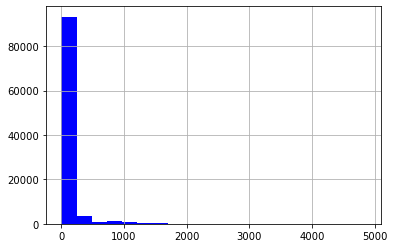

<matplotlib.axes._subplots.AxesSubplot at 0x7fbf660bc370>

In [0]:
target_size_df = target_sub_df.groupby('citation_id').size()
print(target_size_df.rename('citations made').to_frame().describe())
target_size_df.rename('citations made').hist(color="blue", bins = 20)

In [0]:
len(list(np.unique(target_sub_df.patent_id)))

Out[20]: 1129025

In [0]:
# produce final list of all pats
full_pat_list = set(np.unique(study_plus_bkwd_cits_pat_list + list(target_sub_df.patent_id))) 
len(full_pat_list)

Out[21]: 1167363

In [0]:
# combine all citations from patents within the ego network
cit_sub_df = pd.concat ([source_sub_df, target_sub_df], axis = 0)
print (cit_sub_df.shape)
cit_sub_df.head()

(8643212, 9)
Out[22]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
1971,000rst0oc61rl80e8c9t01din,9456983,6258378,2001-07-01,Schneider et al.,B1,US,cited by applicant,2
2779,0013kdlah232ut05gupqgfa6g,9309520,6319703,2001-11-01,Speck,B1,US,cited by applicant,326
3288,001awakfz35mtpipmqmz3h8ey,9343402,6975033,2005-12-01,Ito et al.,B2,US,cited by applicant,6
3345,001buaqi9pat1ya4qk10al4dl,9243616,5272879,1993-12-01,Wiggs,A,US,cited by examiner,2
3373,001c4kwyfwj0p22i447v36eqp,9302260,2284554,1942-05-01,Beyerstedt,A,US,cited by applicant,1


In [0]:
# subset patent df
pat_sub_df = pat_df[pat_df['id'].isin(full_pat_list)]
pat_sub_df.shape

Out[23]: (1163812, 11)

### Sanity check
Quick checks to ensure the data frames are set up correctly before computing disruption scores

In [0]:
'10000023' in study_pat_list

Out[24]: False

In [0]:
test_df = cit_df[cit_df.patent_id == '10000023']

In [0]:
test_df.head()

Out[26]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
4090031,197eg7i2h30zsgdrnee1e29qh,10000023,6570952,2003-05-01,Paladini,B2,US,cited by applicant,19
9107075,2sntq901qbinr8216h8suewdv,10000023,5753171,1998-05-01,Serbin et al.,A,US,cited by applicant,7
12692649,3wbnnd9895z3sajauzspov5r6,10000023,6372178,2002-04-01,Tseng,B1,US,cited by applicant,16
16243296,4zkxtobcv1zqvf53m1nmxlmr9,10000023,5447822,1995-09-01,Hull et al.,A,US,cited by applicant,4
16777316,55h3o5k6h3cfamk05j6aenozs,10000023,6821473,2004-11-01,Hiizumi et al.,B2,US,cited by applicant,20


In [0]:
test_df[test_df.citation_id.isin(study_plus_bkwd_cits_pat_list)]

Out[27]:

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
16243296,4zkxtobcv1zqvf53m1nmxlmr9,10000023,5447822,1995-09-01,Hull et al.,A,US,cited by applicant,4
38196900,bqdee6pdvs5d6601nddp0cvyv,10000023,5876550,1999-03-01,Feygin et al.,A,US,cited by applicant,9
82783087,pffri6u6xlb8wf12wjywpmiwf,10000023,7636610,2009-12-01,Schillen et al.,B2,US,cited by applicant,25
89668689,rjlpo1t4k26tlv15tzm8tdx1g,10000023,6030199,2000-02-01,Tseng,A,US,cited by applicant,13
90710351,rv4boivy3qzkp5v6yqmo9ftip,10000023,5049901,1991-09-01,Gelbart,A,US,cited by applicant,1
104549714,w47c2xjxlq99pwtfdk15zf3zr,10000023,5902537,1999-05-01,Almquist et al.,A,US,cited by applicant,11
108843619,xfou6oscs3nfkuvkmzjj9d660,10000023,7831328,2010-11-01,Schillen et al.,B2,US,cited by applicant,27


## Load graph

In [0]:
# create graph
graph = cdindex.Graph()

In [0]:
# create vertices
pat_vertices =[{"name": x, "time": datetime.fromisoformat(y)} \
               for x, y in zip(pat_sub_df['id'], pat_sub_df['date'])]

# test out
pat_vertices[0:5]

Out[29]: [{'name': '10000000', 'time': datetime.datetime(2018, 6, 19, 0, 0)},
 {'name': '10000011', 'time': datetime.datetime(2018, 6, 19, 0, 0)},
 {'name': '10000015', 'time': datetime.datetime(2018, 6, 19, 0, 0)},
 {'name': '10000016', 'time': datetime.datetime(2018, 6, 19, 0, 0)},
 {'name': '10000023', 'time': datetime.datetime(2018, 6, 19, 0, 0)}]

In [0]:
# add vertices to graph
for vertex in tqdm(pat_vertices):
	graph.add_vertex(vertex["name"], cdindex.timestamp_from_datetime(vertex["time"]))

0%| | 0/1163812 [00:00<?, ?it/s] 1%|▏ | 15816/1163812 [00:00<00:07, 158158.64it/s] 3%|▎ | 31479/1163812 [00:00<00:07, 157696.74it/s] 4%|▍ | 45861/1163812 [00:00<00:07, 153259.80it/s] 5%|▌ | 61510/1163812 [00:00<00:07, 154211.99it/s] 7%|▋ | 76444/1163812 [00:00<00:07, 151985.24it/s] 8%|▊ | 89007/1163812 [00:00<00:07, 139086.97it/s] 9%|▉ | 105179/1163812 [00:00<00:07, 145181.65it/s] 10%|█ | 121371/1163812 [00:00<00:06, 149827.21it/s] 12%|█▏ | 137871/1163812 [00:00<00:06, 154075.10it/s] 13%|█▎ | 154445/1163812 [00:01<00:06, 157397.31it/s] 15%|█▍ | 169874/1163812 [00:01<00:06, 154256.59it/s] 16%|█▌ | 185096/1163812 [00:01<00:06, 149659.32it/s] 17%|█▋ | 202066/1163812 [00:01<00:06, 155154.07it/s] 19%|█▊ | 217554/1163812 [00:01<00:06, 154699.00it/s] 20%|██ | 233005/1163812 [00:01<00:06, 154574.90it/s] 21%|██▏ | 249444/1163812 [00:01<00:05, 157392.33it/s] 23%|██▎ | 265892/1163812 [00:01<00:05, 159451.05it/s] 24%|██▍ | 281846/1163812 [00:01<00:05, 159211.40it/s] 26%|██▌ | 297774/1163812 [00:01<00:05, 151613.32it/s] 27%|██▋ | 313016/1163812 [00:02<00:05, 150360.83it/s] 28%|██▊ | 328111/1163812 [00:02<00:05, 148987.26it/s] 29%|██▉ | 343054/1163812 [00:02<00:05, 147463.76it/s] 31%|███ | 357835/1163812 [00:02<00:05, 138713.84it/s] 32%|███▏ | 372456/1163812 [00:02<00:05, 140879.79it/s] 33%|███▎ | 387499/1163812 [00:02<00:05, 143613.72it/s] 35%|███▍ | 402823/1163812 [00:02<00:05, 146371.22it/s] 36%|███▌ | 418164/1163812 [00:02<00:05, 148412.38it/s] 37%|███▋ | 433062/1163812 [00:02<00:04, 147029.36it/s] 39%|███▊ | 448249/1163812 [00:02<00:04, 148448.57it/s] 40%|███▉ | 463127/1163812 [00:03<00:04, 147572.11it/s] 41%|████ | 478018/1163812 [00:03<00:04, 147968.88it/s] 42%|████▏ | 492833/1163812 [00:03<00:04, 146457.22it/s] 44%|████▎ | 507495/1163812 [00:03<00:04, 145941.46it/s] 45%|████▍ | 522114/1163812 [00:03<00:04, 146013.47it/s] 46%|████▌ | 536831/1163812 [00:03<00:04, 146357.83it/s] 47%|████▋ | 551750/1163812 [00:03<00:04, 147195.65it/s] 49%|████▊ | 566832/1163812 [00:03<00:04, 148263.11it/s] 50%|████▉ | 581664/1163812 [00:03<00:04, 143260.53it/s] 51%|█████▏ | 596891/1163812 [00:03<00:03, 145848.05it/s] 53%|█████▎ | 611516/1163812 [00:04<00:03, 145351.98it/s] 54%|█████▍ | 626902/1163812 [00:04<00:03, 147803.86it/s] 55%|█████▌ | 641713/1163812 [00:04<00:03, 147692.24it/s] 56%|█████▋ | 656504/1163812 [00:04<00:03, 147062.24it/s] 58%|█████▊ | 671226/1163812 [00:04<00:03, 145647.12it/s] 59%|█████▉ | 685805/1163812 [00:04<00:03, 144801.56it/s] 60%|██████ | 700296/1163812 [00:04<00:03, 122330.13it/s] 61%|██████▏ | 715002/1163812 [00:04<00:03, 128828.93it/s] 63%|██████▎ | 729753/1163812 [00:04<00:03, 133916.58it/s] 64%|██████▍ | 744977/1163812 [00:05<00:03, 138933.07it/s] 65%|██████▌ | 759991/1163812 [00:05<00:02, 142115.30it/s] 67%|██████▋ | 774457/1163812 [00:05<00:02, 142272.42it/s] 68%|██████▊ | 789332/1163812 [00:05<00:02, 144154.02it/s] 69%|██████▉ | 803878/1163812 [00:05<00:02, 144281.48it/s] 70%|███████ | 818765/1163812 [00:05<00:02, 145618.21it/s] 72%|███████▏ | 833543/1163812 [00:05<00:02, 146258.26it/s] 73%|███████▎ | 848217/1163812 [00:05<00:02, 145165.30it/s] 74%|███████▍ | 863119/1163812 [00:05<00:02, 146300.44it/s] 75%|███████▌ | 877776/1163812 [00:05<00:01, 145730.20it/s] 77%|███████▋ | 892369/1163812 [00:06<00:01, 144765.71it/s] 78%|███████▊ | 907415/1163812 [00:06<00:01, 146427.75it/s] 79%|███████▉ | 922111/1163812 [00:06<00:01, 146585.49it/s] 80%|████████ | 936781/1163812 [00:06<00:01, 146071.86it/s] 82%|████████▏ | 951396/1163812 [00:06<00:01, 145306.90it/s] 83%|████████▎ | 966067/1163812 [00:06<00:01, 145722.14it/s] 84%|████████▍ | 981425/1163812 [00:06<00:01, 147992.88it/s] 86%|████████▌ | 996779/1163812 [00:06<00:01, 149613.78it/s] 87%|████████▋ | 1011833/1163812 [00:06<00:01, 149889.10it/s] 88%|████████▊ | 1027576/1163812 [00:06<00:00, 152071.93it/s] 90%|████████▉ | 1042815/1163812 [00:07<00:00, 152164.21it/s] 91%|█████████ | 1058042/1163812 [00:07<00:00

In [0]:
print (cit_sub_df.shape)
cit_sub_df.drop_duplicates(subset=['patent_id', 'citation_id'], inplace=True)
print (cit_sub_df.shape)

(8643212, 9)
(8456257, 9)

In [0]:
# create edges
cit_edges = [{"source": x, "target": y} for x, y in zip(cit_sub_df['patent_id'], cit_sub_df['citation_id']) if  (x in full_pat_list) and (y in full_pat_list) ]
print (len(cit_edges))

8456257

In [0]:
graph_vertices = set(graph.vertices())
# add edges
missing_sources = []
missing_targets = []

for edge in tqdm(cit_edges):
  if (edge["source"] not in graph_vertices):
    missing_sources.append(edge)
    continue 
  if (edge["target"] not in graph_vertices):
    missing_targets.append(edge)
    continue 
  graph.add_edge(edge["source"], edge["target"])

0%| | 0/8456257 [00:00<?, ?it/s] 0%| | 11727/8456257 [00:00<01:12, 117269.83it/s] 0%| | 21157/8456257 [00:00<01:17, 109280.80it/s] 0%| | 29863/8456257 [00:00<01:23, 101505.74it/s] 0%| | 37859/8456257 [00:00<01:29, 93913.34it/s]  1%| | 44679/8456257 [00:00<01:42, 81674.37it/s] 1%| | 51332/8456257 [00:00<01:54, 73307.24it/s] 1%| | 57764/8456257 [00:00<02:12, 63366.55it/s] 1%| | 63711/8456257 [00:00<02:26, 57126.59it/s] 1%| | 69268/8456257 [00:01<02:46, 50349.63it/s] 1%| | 74341/8456257 [00:01<03:03, 45660.42it/s] 1%| | 79017/8456257 [00:01<03:25, 40777.35it/s] 1%| | 83270/8456257 [00:01<03:38, 38271.77it/s] 1%| | 87251/8456257 [00:01<03:46, 37027.11it/s] 1%| | 91070/8456257 [00:01<03:44, 37255.22it/s] 1%| | 94878/8456257 [00:01<03:51, 36141.75it/s] 1%| | 98557/8456257 [00:01<03:52, 35945.01it/s] 1%| | 102203/8456257 [00:01<03:51, 36097.19it/s] 1%|▏ | 105845/8456257 [00:02<03:52, 35865.16it/s] 1%|▏ | 109455/8456257 [00:02<03:58, 35056.34it/s] 1%|▏ | 112981/8456257 [00:02<04:15, 32702.99it/s] 1%|▏ | 116298/8456257 [00:02<04:19, 32192.25it/s] 1%|▏ | 119552/8456257 [00:02<04:24, 31543.64it/s] 1%|▏ | 122733/8456257 [00:02<04:36, 30188.74it/s] 1%|▏ | 125783/8456257 [00:02<04:47, 28966.99it/s] 2%|▏ | 128712/8456257 [00:02<04:52, 28473.58it/s] 2%|▏ | 131584/8456257 [00:02<04:52, 28496.16it/s] 2%|▏ | 134495/8456257 [00:03<04:50, 28667.08it/s] 2%|▏ | 137374/8456257 [00:03<04:54, 28295.37it/s] 2%|▏ | 140214/8456257 [00:03<05:11, 26661.58it/s] 2%|▏ | 142907/8456257 [00:03<05:15, 26328.73it/s] 2%|▏ | 145560/8456257 [00:03<05:23, 25662.99it/s] 2%|▏ | 148144/8456257 [00:03<05:29, 25213.39it/s] 2%|▏ | 150680/8456257 [00:03<05:36, 24653.52it/s] 2%|▏ | 153158/8456257 [00:03<05:43, 24192.93it/s] 2%|▏ | 155588/8456257 [00:03<05:49, 23768.60it/s] 2%|▏ | 157974/8456257 [00:04<06:07, 22587.65it/s] 2%|▏ | 160442/8456257 [00:04<05:58, 23137.31it/s] 2%|▏ | 162773/8456257 [00:04<06:17, 21966.98it/s] 2%|▏ | 164994/8456257 [00:04<06:26, 21435.10it/s] 2%|▏ | 167177/8456257 [00:04<06:25, 21525.29it/s] 2%|▏ | 169344/8456257 [00:04<06:26, 21438.71it/s] 2%|▏ | 178552/8456257 [00:04<04:57, 27847.96it/s] 2%|▏ | 196973/8456257 [00:04<03:41, 37362.12it/s] 3%|▎ | 215286/8456257 [00:04<02:47, 49082.67it/s] 3%|▎ | 232659/8456257 [00:04<02:11, 62545.05it/s] 3%|▎ | 249097/8456257 [00:05<01:46, 76822.50it/s] 3%|▎ | 265288/8456257 [00:05<01:29, 91200.63it/s] 3%|▎ | 280080/8456257 [00:05<01:20, 101532.95it/s] 3%|▎ | 294575/8456257 [00:05<01:13, 111330.70it/s] 4%|▎ | 309032/8456257 [00:05<01:08, 118208.38it/s] 4%|▍ | 323296/8456257 [00:05<01:06, 121508.46it/s] 4%|▍ | 337180/8456257 [00:05<01:06, 121666.53it/s] 4%|▍ | 350560/8456257 [00:05<01:07, 119459.66it/s] 4%|▍ | 363364/8456257 [00:05<01:08, 118017.91it/s] 4%|▍ | 375771/8456257 [00:06<01:09, 116816.38it/s] 5%|▍ | 387879/8456257 [00:06<01:10, 114015.42it/s] 5%|▍ | 399594/8456257 [00:06<01:12, 111035.56it/s] 5%|▍ | 410934/8456257 [00:06<01:12, 111311.68it/s] 5%|▍ | 422231/8456257 [00:06<01:12, 111096.92it/s] 5%|▌ | 433457/8456257 [00:06<01:13, 109541.00it/s] 5%|▌ | 444630/8456257 [00:06<01:12, 110184.24it/s] 5%|▌ | 455710/8456257 [00:06<01:14, 107239.43it/s] 6%|▌ | 466495/8456257 [00:06<01:14, 106663.91it/s] 6%|▌ | 477205/8456257 [00:06<01:15, 106268.93it/s] 6%|▌ | 487863/8456257 [00:07<01:17, 103137.86it/s] 6%|▌ | 498219/8456257 [00:07<01:18, 101093.07it/s] 6%|▌ | 508367/8456257 [00:07<01:20, 98545.05it/s]  6%|▌ | 518263/8456257 [00:07<01:21, 97871.83it/s] 6%|▌ | 528080/8456257 [00:07<01:22, 96369.16it/s] 6%|▋ | 537758/8456257 [00:07<01:22, 96489.39it/s] 6%|▋ | 547426/8456257 [00:07<01:23, 95082.36it/s] 7%|▋ | 556952/8456257 [00:07<01:24, 93426.09it/s] 7%|▋ | 566314/8456257 [00:07<01:25, 92619.62it/s] 7%|▋ | 575591/8456257 [00:08<01:27, 90385.90it/s] 7%|▋ | 584652/8456257 [00:08<01:27, 90325.66it/s] 7%|▋ | 593701/8456257 [00:08<01:29, 87808.14it/s] 7%|▋ | 602509/8456257 [00:08<01:32, 84974.13it/s] 7%|▋ | 611045/8456257 [00:08<01:32, 85051.71it/s

In [0]:
print (len(missing_sources))
print (len(missing_targets)) # there are ~207K missing targets in the patent vertice list 

len(set([v['target'] for v in missing_targets])) # once uniqing that adds up to 3551

0
206924
Out[34]: 3551

## Compute scores

In [0]:
cd_index_5 = {}
mcd_index_5 = {}
for patent_id in tqdm(study_pat_list):
  cd_index_5[patent_id] = graph.cdindex(patent_id, int(timedelta(days=1825).total_seconds()))
  mcd_index_5[patent_id] = graph.mcdindex(patent_id, int(timedelta(days=1825).total_seconds()))

0%| | 0/12417 [00:00<?, ?it/s] 0%| | 37/12417 [00:00<00:43, 281.83it/s] 1%| | 72/12417 [00:00<00:42, 291.53it/s] 1%| | 88/12417 [00:00<02:47, 73.74it/s]  1%| | 100/12417 [00:00<02:32, 80.73it/s] 1%| | 112/12417 [00:01<02:23, 85.82it/s] 1%|▏ | 184/12417 [00:01<01:49, 112.19it/s] 2%|▏ | 228/12417 [00:01<01:28, 138.39it/s] 2%|▏ | 251/12417 [00:01<02:31, 80.27it/s]  2%|▏ | 285/12417 [00:02<02:11, 92.26it/s] 2%|▏ | 302/12417 [00:02<01:57, 102.96it/s] 3%|▎ | 332/12417 [00:02<01:41, 119.40it/s] 3%|▎ | 349/12417 [00:02<01:58, 102.01it/s] 3%|▎ | 400/12417 [00:02<01:31, 130.64it/s] 3%|▎ | 422/12417 [00:02<01:22, 145.51it/s] 4%|▎ | 443/12417 [00:03<02:09, 92.49it/s]  4%|▎ | 460/12417 [00:03<02:12, 90.23it/s] 4%|▍ | 525/12417 [00:03<01:39, 119.45it/s] 4%|▍ | 550/12417 [00:03<01:25, 138.71it/s] 5%|▍ | 574/12417 [00:04<01:29, 132.28it/s] 5%|▌ | 667/12417 [00:04<01:07, 173.56it/s] 6%|▌ | 701/12417 [00:04<01:09, 168.18it/s] 6%|▌ | 729/12417 [00:04<01:10, 164.77it/s] 6%|▌ | 769/12417 [00:04<00:59, 196.52it/s] 6%|▋ | 797/12417 [00:04<00:57, 203.38it/s] 7%|▋ | 824/12417 [00:05<01:34, 123.23it/s] 7%|▋ | 908/12417 [00:05<01:11, 160.48it/s] 8%|▊ | 1017/12417 [00:05<00:55, 205.44it/s] 9%|▊ | 1057/12417 [00:05<00:56, 200.50it/s] 9%|▉ | 1091/12417 [00:06<01:10, 159.72it/s] 9%|▉ | 1127/12417 [00:06<01:11, 158.06it/s] 10%|▉ | 1182/12417 [00:06<00:56, 200.01it/s] 10%|▉ | 1214/12417 [00:06<01:08, 163.19it/s] 10%|▉ | 1240/12417 [00:06<01:17, 144.25it/s] 10%|█ | 1303/12417 [00:07<00:59, 185.54it/s] 11%|█ | 1335/12417 [00:07<01:03, 175.50it/s] 11%|█ | 1386/12417 [00:07<00:51, 214.58it/s] 11%|█▏ | 1419/12417 [00:07<00:47, 230.80it/s] 12%|█▏ | 1450/12417 [00:07<01:09, 158.33it/s] 12%|█▏ | 1514/12417 [00:07<00:56, 192.18it/s] 12%|█▏ | 1543/12417 [00:08<00:52, 209.01it/s] 13%|█▎ | 1571/12417 [00:08<00:57, 187.39it/s] 13%|█▎ | 1596/12417 [00:08<01:46, 101.80it/s] 14%|█▎ | 1695/12417 [00:08<01:18, 136.31it/s] 14%|█▍ | 1728/12417 [00:09<01:33, 114.86it/s] 15%|█▍ | 1811/12417 [00:09<01:10, 151.34it/s] 15%|█▍ | 1847/12417 [00:09<01:30, 116.55it/s] 15%|█▌ | 1874/12417 [00:10<01:15, 140.49it/s] 15%|█▌ | 1924/12417 [00:10<00:59, 176.50it/s] 16%|█▌ | 1957/12417 [00:10<01:50, 94.37it/s]  17%|█▋ | 2061/12417 [00:10<01:19, 129.77it/s] 17%|█▋ | 2109/12417 [00:11<01:39, 104.11it/s] 18%|█▊ | 2197/12417 [00:11<01:13, 138.22it/s] 18%|█▊ | 2240/12417 [00:12<01:14, 137.21it/s] 18%|█▊ | 2274/12417 [00:12<01:08, 148.61it/s] 19%|█▉ | 2334/12417 [00:12<00:54, 186.27it/s] 19%|█▉ | 2386/12417 [00:12<00:43, 229.70it/s] 20%|█▉ | 2425/12417 [00:12<01:02, 159.92it/s] 20%|██ | 2488/12417 [00:13<00:48, 202.66it/s] 20%|██ | 2526/12417 [00:13<00:51, 191.61it/s] 21%|██ | 2615/12417 [00:13<00:39, 248.32it/s] 21%|██▏ | 2661/12417 [00:13<00:53, 182.41it/s] 22%|██▏ | 2697/12417 [00:14<00:54, 179.62it/s] 22%|██▏ | 2728/12417 [00:14<00:55, 174.41it/s] 23%|██▎ | 2813/12417 [00:14<00:44, 216.56it/s] 23%|██▎ | 2847/12417 [00:14<01:09, 137.42it/s] 24%|██▎ | 2936/12417 [00:14<00:51, 182.81it/s] 24%|██▍ | 2978/12417 [00:15<01:12, 130.77it/s] 24%|██▍ | 3010/12417 [00:15<01:04, 145.09it/s] 25%|██▌ | 3111/12417 [00:15<00:48, 191.77it/s] 25%|██▌ | 3154/12417 [00:16<00:55, 168.06it/s] 26%|██▌ | 3251/12417 [00:16<00:43, 212.68it/s] 27%|██▋ | 3292/12417 [00:16<01:11, 128.00it/s] 27%|██▋ | 3338/12417 [00:17<00:57, 156.74it/s] 27%|██▋ | 3370/12417 [00:17<00:53, 168.21it/s] 27%|██▋ | 3398/12417 [00:17<01:16, 118.50it/s] 28%|██▊ | 3420/12417 [00:17<01:24, 106.39it/s] 28%|██▊ | 3504/12417 [00:17<01:02, 142.97it/s] 29%|██▊ | 3539/12417 [00:18<00:52, 169.13it/s] 29%|██▉ | 3614/12417 [00:18<00:40, 219.74it/s] 29%|██▉ | 3659/12417 [00:18<00:37, 236.27it/s] 30%|██▉ | 3702/12417 [00:18<00:32, 270.67it/s] 30%|███ | 3743/12417 [00:18<00:38, 223.88it/s] 30%|███ | 3778/12417 [00:18<00:37, 231.20it/s] 31%|███ | 3827/12417 [00:18<00:32, 265.81it/s] 31%|███ | 3861/12417 [00:19<01:06, 128.68it/s] 32%|███▏ | 4016/12417 [00:19<00:47, 177.01it/s] 33%

In [0]:
cd_index_5_clnd = {k: v for k, v in cd_index_5.items() if v is not None}

sorted_keys = sorted(cd_index_5_clnd, key=cd_index_5_clnd.get, reverse=True)
for sk in sorted_keys:
    print(sk, cd_index_5_clnd[sk])

9198873 1.0
9200378 1.0
9200974 1.0
9201266 1.0
9202556 1.0
9203030 1.0
9203038 1.0
9203040 1.0
9203095 1.0
9206350 1.0
9209025 1.0
9209282 1.0
9209374 1.0
9209413 1.0
9212063 1.0
9212268 1.0
9212285 1.0
9212389 1.0
9213929 1.0
9214239 1.0
9214788 1.0
9216225 1.0
9216908 1.0
9218959 1.0
9219008 1.0
9219175 1.0
9220951 1.0
9220998 1.0
9224597 1.0
9224749 1.0
9224816 1.0
9224877 1.0
9224910 1.0
9224920 1.0
9224985 1.0
9227393 1.0
9227846 1.0
9227941 1.0
9228010 1.0
9228244 1.0
9228974 1.0
9230793 1.0
9230799 1.0
9231066 1.0
9231169 1.0
9231214 1.0
9233492 1.0
9233930 1.0
9234084 1.0
9234633 1.0
9234882 1.0
9236162 1.0
9236197 1.0
9236405 1.0
9236412 1.0
9236461 1.0
9236491 1.0
9238700 1.0
9239224 1.0
9240451 1.0
9240485 1.0
9240567 1.0
9241115 1.0
9241913 1.0
9242433 1.0
9242861 1.0
9242865 1.0
9243141 1.0
9243159 1.0
9244296 1.0
9245851 1.0
9245962 1.0
9246461 1.0
9248441 1.0
9249250 1.0
9250528 1.0
9251910 1.0
9251968 1.0
9252392 1.0
9252985 1.0
9256300 1.0
9257167 1.0
9257237 1.0
9257510 1.0
9257538 1.0
9257660 1.0
9259005 1.0
9260652 1.0
9261472 1.0
9263187 1.0
9263253 1.0
9263269 1.0
9263456 1.0
9263570 1.0
9264795 1.0
9264796 1.0
9265169 1.0
9266172 1.0
9267664 1.0
9268451 1.0
9269419 1.0
9269764 1.0
9269827 1.0
9269839 1.0
9269852 1.0
9269873 1.0
9272043 1.0
9272158 1.0
9273248 1.0
9273352 1.0
9274391 1.0
9275322 1.0
9275857 1.0
9275926 1.0
9276064 1.0
9276122 1.0
9276123 1.0
9276126 1.0
9276144 1.0
9276216 1.0
9278069 1.0
9278162 1.0
9278862 1.0
9280044 1.0
9281104 1.0
9281276 1.0
9281298 1.0
9281318 1.0
9281384 1.0
9281385 1.0
9281443 1.0
9281484 1.0
9283386 1.0
9283545 1.0
9283619 1.0
9284193 1.0
9284381 1.0
9284640 1.0
9285336 1.0
9286981 1.0
9287132 1.0
9287189 1.0
9287259 1.0
9287388 1.0
9287395 1.0
9287439 1.0
9287518 1.0
9290524 1.0
9291513 1.0
9291618 1.0
9293381 1.0
9293446 1.0
9293496 1.0
9293536 1.0
9293564 1.0
9293573 1.0
9293753 1.0
9296609 1.0
9296623 1.0
9296625 1.0
9296944 1.0
9297013 1.0
9299637 1.0
9299732 1.0
9300115 1.0
9305652 1.0
9305780 1.0
9305859 1.0
9305869 1.0
9305875 1.0
9305888 1.0
9306026 1.0
9306099 1.0
9306111 1.0
9306646 1.0
9307641 1.0
9308243 1.0
9309432 1.0
9310673 1.0
9312021 1.0
9312165 1.0
9312353 1.0
9312401 1.0
9312434 1.0
9312447 1.0
9312491 1.0
9312885 1.0
9315387 1.0
9315420 1.0
9315679 1.0
9317473 1.0
9318159 1.0
9318196 1.0
9318461 1.0
9318532 1.0
9318600 1.0
9318650 1.0
9318707 1.0
9319569 1.0
9320749 1.0
9322134 1.0
9322979 1.0
9324504 1.0
9324587 1.0
9324804 1.0
9324826 1.0
9324880 1.0
9327966 1.0
9327979 1.0
9327981 1.0
9327983 1.0
9327985 1.0
9329203 1.0
9329445 1.0
9330768 1.0
9330903 1.0
9330982 1.0
9331044 1.0
9331126 1.0
9331163 1.0
9331165 1.0
9331198 1.0
9331300 1.0
9332751 1.0
9333271 1.0
9334168 1.0
9335689 1.0
9337015 1.0
9337080 1.0
9337083 1.0
9337212 1.0
9337226 1.0
9337230 1.0
9337420 1.0
9337481 1.0
9339539 1.0
9339557 1.0
9339790 1.0
9339870 1.0
9340692 1.0
9341559 1.0
9341763 1.0
9343296 1.0
9343601 1.0
9346986 1.0
9347143 1.0
9347872 1.0
9347923 1.0
9349403 1.0
9349538 1.0
9349644 1.0
9349687 1.0
9349694 1.0
9349855 1.0
9349860 1.0
9352862 1.0
9353339 1.0
9353433 1.0
9354741 1.0
9355852 1.0
9355913 1.0
9355916 1.0
9356187 1.0
9356241 1.0
9359202 1.0
9359208 1.0
9359396 1.0
9360375 1.0
9362177 1.0
9362308 1.0
9362489 1.0
9364438 1.0
9365427 1.0
9365513 1.0
9365659 1.0
9365792 1.0
9365921 1.0
9366647 1.0
9368393 1.0
9368409 1.0
9368525 1.0
9368579 1.0
9368635 1.0
9368676 1.0
9368737 1.0
9368793 1.0
9368941 1.0
9371234 1.0
9371235 1.0
9371441 1.0
9371451 1.0
9373390 1.0
9373547 1.0
9373693 1.0
9373748 1.0
9373749 1.0
9373846 1.0
9373863 1.0
9376468 1.0
9377571 1.0
9379131 1.0
9379249 1.0
9382548 1.0
9383299 1.0
9384875 1.0
9385040 1.0
9385148 1.0
9385192 1.0
9385280 1.0
9388049 1.0
9390781 1.0
9390911 1.0
9391187 1.0
9391213 1.0
9391229 1.0
9391268 1.0
9391287 1.0
9392735 1.0
9392794 1.0
9395068 1.0
9396940 1.0
9397204 1.0
9399357 1.0
9399374 1.0
9399578 1.0
9399581 1.0
9399736 1.0
9401135 1.0
9401191 1.0
9401219 1.0
9401272 1.0
9401376 1.0
9401388 1.0
9401

In [0]:
# compare sample frame patents with number of patents with non-null cd_index scores
print (len(cd_index_5))
print (len(cd_index_5_clnd))
print ('percentage with non-null values: ' + str(len(cd_index_5_clnd) / len(cd_index_5) ))

12417
10584
percentage with non-null values: 0.8523798018845131

In [0]:
mcd_index_5_clnd = {k: v for k, v in mcd_index_5.items() if v is not None}

sorted_keys = sorted(mcd_index_5_clnd, key=mcd_index_5_clnd.get, reverse=True)
for sk in sorted_keys:
    print(sk, mcd_index_5_clnd[sk])

9246334 126.0
9368671 99.62068965517241
9252024 96.53284671532846
9229964 94.2936507936508
9240469 88.88961038961038
9337057 70.54838709677419
9502265 59.60591133004926
9514932 57.19140625
9281384 48.0
9202996 47.20689655172414
9449720 35.55555555555556
9249526 35.06349206349206
9472618 32.790419161676645
9484406 30.0
9325173 28.125
9349687 27.0
9362161 26.74074074074074
9209081 24.03846153846154
9478324 23.058823529411764
9306026 22.0
9490407 22.0
9520289 21.78723404255319
9231129 21.0
9257575 21.0
9324696 20.742424242424242
9388048 20.166666666666664
9312401 20.0
9541578 19.047619047619047
9276064 19.0
9442338 18.0
9502133 18.0
9227790 18.0
9216172 18.0
9293459 17.06451612903226
9227393 17.0
9246046 17.0
9263601 17.0
9312042 17.0
9362427 17.0
9263622 16.055555555555554
9278069 16.0
9456992 16.0
9362413 14.727272727272728
9232290 14.0625
9406877 14.0
9469896 14.0
9500519 14.0
9570551 13.927536231884059
9322437 13.884615384615383
9398422 13.714285714285714
9425318 13.0
9533914 13.0
9437370 12.8
9312425 12.565217391304348
9428757 12.32
9412752 12.275541795665633
9235236 12.266129032258064
9245962 12.0
9318650 12.0
9437871 12.0
9306646 11.0
9458169 11.0
9520466 10.93939393939394
9484447 10.31578947368421
9213929 10.0
9299732 10.0
9376468 10.0
9484155 10.0
9572304 10.0
9221788 10.0
9234013 10.0
9238674 10.0
9328427 9.96551724137931
9337369 9.5
9439332 9.333333333333332
9276050 9.307692307692308
9362487 9.307692307692308
9455300 9.107142857142858
9269839 9.0
9349860 9.0
9209323 9.0
9281442 8.5
9216434 8.470588235294118
9287270 8.333333333333334
9293564 8.0
9391287 8.0
9392735 8.0
9431593 8.0
9443856 8.0
9443899 8.0
9449377 8.0
9494734 8.0
9513244 8.0
9528132 8.0
9199994 8.0
9371568 8.0
9224902 7.225
9236412 7.0
9425804 7.0
9496068 7.0
9243303 7.0
9496448 7.0
9309220 7.0
9428541 7.0
9412817 6.609870740305523
9330906 6.576923076923077
9240464 6.4
9355873 6.25
9502509 6.136363636363637
9406694 6.041095890410959
9243141 6.0
9251910 6.0
9273352 6.0
9324826 6.0
9324880 6.0
9337230 6.0
9355913 6.0
9359208 6.0
9362177 6.0
9377571 6.0
9422234 6.0
9543156 6.0
9548085 6.0
9236526 5.921052631578948
9287442 5.815789473684211
9287455 5.793103448275862
9580341 5.764705882352941
9226361 5.510416666666667
9263625 5.474576271186441
9548494 5.444444444444445
9324692 5.377777777777777
9252275 5.263157894736842
9437716 5.142857142857142
9461149 5.0625
9236461 5.0
9269852 5.0
9269873 5.0
9281385 5.0
9291618 5.0
9297912 5.0
9305869 5.0
9317473 5.0
9318196 5.0
9347923 5.0
9365921 5.0
9390781 5.0
9399357 5.0
9417141 5.0
9418926 5.0
9472468 5.0
9478261 5.0
9496365 5.0
9502526 5.0
9508782 5.0
9515290 5.0
9530873 5.0
9577049 5.0
9581759 5.0
9583538 5.0
9312724 5.0
9318635 5.0
9365679 5.0
9462754 5.0
9315825 5.0
9359445 5.0
9393257 5.0
9534222 5.0
9357212 4.8999999999999995
9228697 4.875
9507390 4.846153846153846
9431539 4.571428571428571
9391086 4.545454545454545
9275772 4.5
9495991 4.430769230769231
9417209 4.413793103448276
9368580 4.363636363636363
9432254 4.266666666666667
9412977 4.166666666666667
9443652 4.166666666666667
9231209 4.083333333333334
9433681 4.081632653061225
9201266 4.0
9224877 4.0
9252108 4.0
9272043 4.0
9287388 4.0
9287395 4.0
9296609 4.0
9296625 4.0
9312165 4.0
9318500 4.0
9327985 4.0
9330903 4.0
9330982 4.0
9331163 4.0
9341763 4.0
9368579 4.0
9373693 4.0
9385148 4.0
9391268 4.0
9397204 4.0
9406705 4.0
9412788 4.0
9449994 4.0
9453811 4.0
9477024 4.0
9516428 4.0
9536735 4.0
9588274 4.0
9318625 4.0
9349883 4.0
9444285 4.0
9500341 4.0
9259481 4.0
9370551 4.0
9415567 4.0
9529433 3.977443609022556
9583491 3.8235294117647056
9293624 3.7532467532467533
9225199 3.7037037037037033
9249032 3.681818181818182
9455430 3.6666666666666665
9263602 3.6125
9397043 3.5999999999999996
9330936 3.5714285714285716
9543322 3.5714285714285716
9276432 3.5714285714285716
9356281 3.506849315068493
9337203 3.5
9431609 3.5
9391262 3.4285714285714284
9279457 3.418604651162791
9287431 3.4000000000000004
9412432 3.2727272727272725
9417302 3.2702702702702706
9329600 3

In [0]:
# compare sample frame patents with number of patents with non-null cd_index scores
print (len(mcd_index_5))
print (len(mcd_index_5_clnd))
print ('percentage with non-null values: ' + str(len(mcd_index_5_clnd) / len(mcd_index_5) ))

12417
10584
percentage with non-null values: 0.8523798018845131

## Write output files

In [0]:
# define file out and write method
CD_FILE = DATA_DIR + 'cd_index.csv'
MCD_FILE = DATA_DIR + 'mcd_index.csv'

def write_csv (out_dict, file_name, col_names):
  with open(file_name, 'w') as csv_file:
      writer = csv.writer(csv_file)
      writer.writerow (col_names)
      for key, value in out_dict.items():
         writer.writerow([key, value])

In [0]:
write_csv (cd_index_5, CD_FILE, ['patent_id', 'cd_index_5'])
write_csv (mcd_index_5, MCD_FILE, ['patent_id', 'mcd_index_5'])